# Model—Machine Learning Surrogate for MuSHrooM 

### *Comments*

**Ways to Improve Performance:**
- Increase Encoder/Decoder Complexity
- Increase latent-space dimensionality
- Decrease timestep between data
- Get more training data
- Make DNN deeper/wider

- Look at custom padding

## Introduction
### Code Structure / Outline
1) Train CVAE Model
2) Train DNN (Using Generated Points in Latent Space)
3) Define and Use GAIT Model

In [1]:
# general imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# data loading and processing
import h5py
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 1 CVAE Model

### Set hyperparameters

In [2]:

# model training
lr_cvae = 0.001
num_epochs_cvae = 20 

lr_dnn = 0.001
num_epochs_dnn = 10000

# model data
batch_size_cvae = 32
input_dim = 64 # for square images
latent_dim = 128

batch_size_dnn = 32

# loss weighting
w_phi = 1.0
w_grad = 10.0
w_kl = 0.01

In [3]:
hdf5_filepath = 'C:/Users/lukas/OneDrive - Yale University/Personal/Studies/Semester 3/S&DS 689/Project/test_datah5.h5'
# '/Users/iangill/Downloads/test_MuSHrooM_processed-60024954.h5'

### Load Test and Train Data

In [4]:
# Open the HDF5 file in read mode
with h5py.File(hdf5_filepath, 'r') as f:
    # Read the datasets
    #tempIon_data = f['tempIon_data'][:]
    #denIon_data = f['denIon_data'][:]
    #tempElc_data = f['tempElc_data'][:]
    #denElc_data = f['denElc_data'][:]
    phi_data = f['phi_data'][:]
    times = f['times'][:]
    grid = f['X'][:]
    # Read the attributes (dimensions of data)
    Nx = f.attrs['Nx']
    Ny = f.attrs['Ny']
    Nt = f.attrs['Nt']

# exchange time dimension with batch dimension
phi_data = np.transpose(phi_data, (2, 1, 0))
print("Shape of data:", phi_data.shape)

Shape of data: (544, 682, 683)


Downsample dataset

[[-4.01058453e-05 -3.94273427e-05 -4.08487707e-05 ... -3.02956791e-05
  -3.25936604e-05 -3.91318028e-05]
 [-3.63544663e-05 -4.12444018e-05 -3.79457082e-05 ... -3.84012423e-05
  -3.62151604e-05 -2.98206949e-05]
 [-3.67277783e-05 -3.88534511e-05 -3.76502480e-05 ... -3.43533494e-05
  -2.90790382e-05 -3.57766532e-05]
 ...
 [-4.18358134e-05 -4.16202291e-05 -3.44037011e-05 ... -4.12722044e-05
  -3.95388825e-05 -4.28543990e-05]
 [-4.17010287e-05 -4.08291292e-05 -3.61093649e-05 ... -4.44339917e-05
  -4.33578221e-05 -4.45099562e-05]
 [-4.26931126e-05 -3.78134087e-05 -3.56040216e-05 ... -3.88133051e-05
  -4.23306340e-05 -4.62097821e-05]]


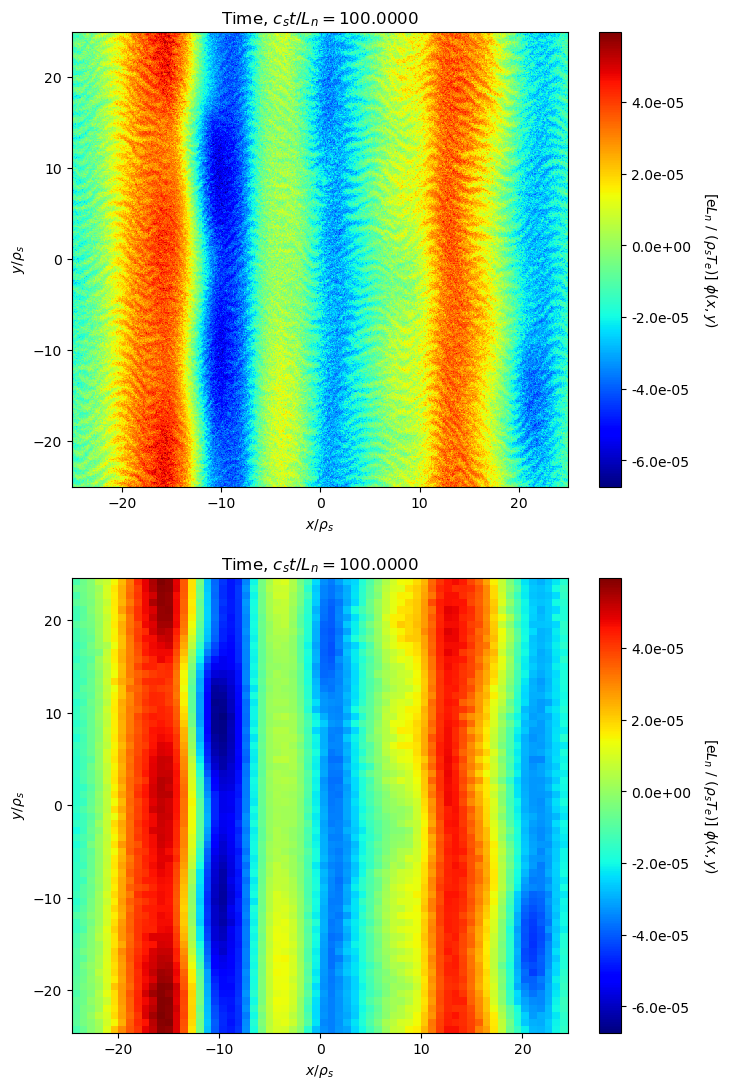

Shape of data: (544, 64, 64)


In [5]:
# Define transform for resizing
input_dim = 64  # Target dimension for resizing
transform = transforms.Resize((input_dim, input_dim))  # Resizing to (64, 64)

# Select a test slice from phi_data
test = torch.tensor(phi_data[400, :, :].copy())  # Select test slice (2D spatial slice)
print(phi_data[1, :, :])

  # Add batch dimension for resizing

# Resize the x and y coordinate grids in `grid`
x_coords = torch.tensor(grid[0, :, :]).unsqueeze(0)  # Add batch dimension for resizing
y_coords = torch.tensor(grid[1, :, :]).unsqueeze(0)
fig, axs= plt.subplots(2,1,figsize=(8, 13))
ax1=axs[1]
ax2=axs[0]
cax2 = ax2.imshow(phi_data[400, :, :], cmap='jet', interpolation='nearest',
                extent=[x_coords.min(), x_coords.max(), 
                        y_coords.min(), y_coords.max()],
                origin='lower', aspect='auto')
test = test.unsqueeze(0)
resized_test = transform(test).squeeze().numpy()



resized_x_coords = transform(x_coords).squeeze().numpy()  # Resize x-coordinates
resized_y_coords = transform(y_coords).squeeze().numpy()  # Resize y-coordinates

# Set up the heatmap plot


# Plot the data using imshow, with the extent matching the x and y grid limits
cax = ax1.imshow(resized_test, cmap='jet', interpolation='nearest',
                extent=[resized_x_coords.min(), resized_x_coords.max(), 
                        resized_y_coords.min(), resized_y_coords.max()],
                origin='lower', aspect='auto')

# Add colorbar with scientific notation
cbar = fig.colorbar(cax, ax=ax2, format='%.1e')
cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
cbar2 = fig.colorbar(cax, ax=ax1, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)

# Set title and labels
time_value = times[0]  # Replace with dynamic time value if available
ax1.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')
ax2.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')

plt.show()

phi_data = torch.tensor(phi_data.copy())
phi_data = transform(phi_data).numpy().astype(np.float32) 
print("Shape of data:", phi_data.shape)

def rescale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
phi_data = rescale(phi_data)


Define Dataset and create DataLoader

Train Data Loader
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
Test Data Loader
torch.Size([32, 1, 64, 64])
torch.float32


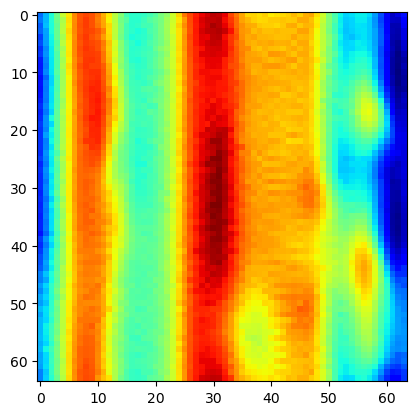

In [6]:
# define class for dataset
class PhiDataset(Dataset):
    def __init__(self, phi_data, transform=None):
        self.data = phi_data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx,:,:], dtype=torch.float32)
        # Add a channel dimension to make it (1, 256, 256)
        image = image.unsqueeze(0)  # Shape becomes (1, 256, 256)

        if self.transform:
            image = self.transform(image)

        return image
    
N_train = batch_size_cvae*16

# train data loader
phi_train = PhiDataset(phi_data[0:N_train, :, :])
phi_train_loader = DataLoader(phi_train, batch_size=batch_size_cvae, shuffle=True)

# test data loader
phi_test = PhiDataset(phi_data[N_train:, :, :])
phi_test_loader = DataLoader(phi_test, batch_size=batch_size_cvae, shuffle=True)


# test data loader
print("Train Data Loader")
for batch in phi_train_loader:
    print(batch.shape)  
    
print("Test Data Loader")
for batch in phi_test_loader:
    print(batch.shape)

# plot the 5th element of the dataset
plt.figure()
plt.imshow(phi_train[10].squeeze(), cmap='jet')

first_batch = next(iter(phi_train_loader))

print(first_batch.dtype)

### Model Architecture: Encoder Network

- **Encoder** $\epsilon$ (CNN):
    - Conv2D Layer with kernel size $4 \times 4$, stride=2, padding=1  
      $[\text{In: } 1 \times 64 \times 64 \text{ Out: } 32 \times 32 \times 32]$
    - Conv2D Layer with kernel size $4 \times 4$, stride=2, padding=1  
      $[\text{In: } 32 \times 32 \times 32 \text{ Out: } 64 \times 16 \times 16]$
    - Conv2D Layer with kernel size $3 \times 3$, stride=1, padding=1  
      $[\text{In: } 64 \times 16 \times 16 \text{ Out: } 128 \times 16 \times 16]$
    - Conv2D Layer with kernel size $4 \times 4$, stride=2, padding=1  
      $[\text{In: } 128 \times 16 \times 16 \text{ Out: } 256 \times 8 \times 8]$
    - Conv2D Layer with kernel size $3 \times 3$, stride=1, padding=1  
      $[\text{In: } 256 \times 8 \times 8 \text{ Out: } 256 \times 8 \times 8]$
    - Flattening Layer  
      $[\text{In: } 256 \times 8 \times 8 \text{ Out: } 16384]$
    - Fully Connected Layers:
        - Mean vector ($\mu$) Layer  
          $[\text{In: } 16384 \text{ Out: } \text{latent\_dim}]$  
          — Center of latent distribution
        - Log-variance vector ($\log{\sigma^2}$) Layer  
          $[\text{In: } 16384 \text{ Out: } \text{latent\_dim}]$  
          — Spread of latent distribution

- **Latent Space (Sampling)**:
    - Latent vector $\mathcal{z}$:  
    $$\mathcal{z} = \mu + e^{\frac{\log{\sigma^2}}{2}} \cdot \epsilon \quad \text{where } \epsilon \sim \mathcal{N}(0, I)$$


In [7]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # 64x64 -> 32x32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 32x32 -> 16x16
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 16x16 -> 16x16
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 16x16 -> 8x8
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.bn5 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        # Apply convolution -> batch normalization -> activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)
        
        # Compute mu and logvar for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

Define Model Components

In [8]:
# test
encoder = Encoder(latent_dim)
mu, logvar = encoder(first_batch)

print(mu.size())

torch.Size([32, 128])


In [9]:
# test reparametrization
def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

z = reparameterize(mu, logvar)

print(z.size())

torch.Size([32, 128])


In [10]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        # Fully connected layer to project latent space to feature map
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        
        # Deconvolutional layers
        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)   # 16x16 -> 16x16
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)     # 32x32 -> 64x64

    def forward(self, z):
        # Project latent space to feature map
        z = F.relu(self.fc(z))
        z = z.view(z.size(0), 256, 8, 8)  # Reshape to (batch_size, 256, 8, 8)
        
        # Apply deconvolution -> activation
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        return torch.sigmoid(self.deconv5(z))  # Output scaled between 0 and 1



In [11]:
# test
decoder = Decoder(latent_dim)
reconstructed_batch = decoder(z)

In [12]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar, z # return reconstructed data, mu, logvar, and the latent state z

torch.Size([32, 1, 64, 64])


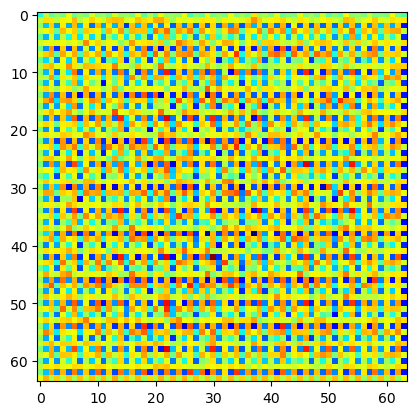

In [13]:
# test
cvae = CVAE(latent_dim)
recon_batch, mu, logvar, z = cvae(first_batch)

print(recon_batch.size())

# print first reconstructed image
plt.figure()
plt.imshow(recon_batch[0].squeeze().detach().numpy(), cmap='jet')


Define Loss Function

Our 3 weighted terms are:
1) reconstruction loss of $\phi$
2) reconstruction loss of $\nabla \phi$
3) KL divergence

In [14]:
# define function to get gradient loss
def gradient_loss(recon_x, x):
    # Ensure gradients can be computed
    x.requires_grad_(True)
    recon_x.requires_grad_(True)

    # Compute gradient of input with respect to spatial dimensions
    grad_input = torch.autograd.grad(outputs=x.sum(), inputs=x, create_graph=True)[0]

    # Compute gradient of output (reconstructed) with respect to spatial dimensions
    grad_output = torch.autograd.grad(outputs=recon_x.sum(), inputs=recon_x, create_graph=True)[0]

    # Compute L2 norm of the difference between the gradients
    grad_loss = F.mse_loss(grad_output, grad_input, reduction='sum')
    
    return grad_loss


def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') # might need to change to L2 norm
    
    recon_grad_loss = gradient_loss(recon_x, x)
    
    # KL divergence - regularizes the distribution of the latent space to be close to a standard normal distribution
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return w_phi*recon_loss + w_grad*recon_grad_loss + w_kl*kl_divergence

In [15]:
# test
loss = loss_function(recon_batch, first_batch, mu, logvar)

print(loss)

tensor(5335.6719, grad_fn=<AddBackward0>)


Initialize Model and Optimizer

In [16]:
model = CVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr_cvae)

### Load Model (Optional)

In [20]:
# load model
model.load_state_dict(torch.load('CVAE Training/CVAE_2/CVAE_model_2.pth'))

C:\Users\lukas\AppData\Local\Temp\ipykernel_8196\3135493144.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CVAE Training/CVAE_2/CVAE_m

<All keys matched successfully>

Train Model

In [ ]:
# # Training loop
# for epoch in range(num_epochs_cvae):
#     model.train()
#     train_loss = 0
#     for i, batch in enumerate(phi_train_loader):
#         optimizer.zero_grad()
#         recon_batch, mu, logvar, z = model(batch)
#         loss = loss_function(recon_batch, batch, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
    
#     avg_loss = train_loss / len(phi_train_loader.dataset)
#     print(f"Epoch {epoch+1}/{num_epochs_cvae}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 110.1753
Epoch 2/20, Loss: 41.0149
Epoch 3/20, Loss: 22.1835
Epoch 4/20, Loss: 15.0406
Epoch 5/20, Loss: 11.9803
Epoch 6/20, Loss: 10.7906
Epoch 7/20, Loss: 12.0918
Epoch 8/20, Loss: 9.1937
Epoch 9/20, Loss: 8.2252
Epoch 10/20, Loss: 8.7523
Epoch 11/20, Loss: 7.3825
Epoch 12/20, Loss: 6.7752
Epoch 13/20, Loss: 7.2845
Epoch 14/20, Loss: 6.0658
Epoch 15/20, Loss: 5.5622
Epoch 16/20, Loss: 5.5731
Epoch 17/20, Loss: 5.1036
Epoch 18/20, Loss: 6.3582
Epoch 19/20, Loss: 7.0771
Epoch 20/20, Loss: 6.7777


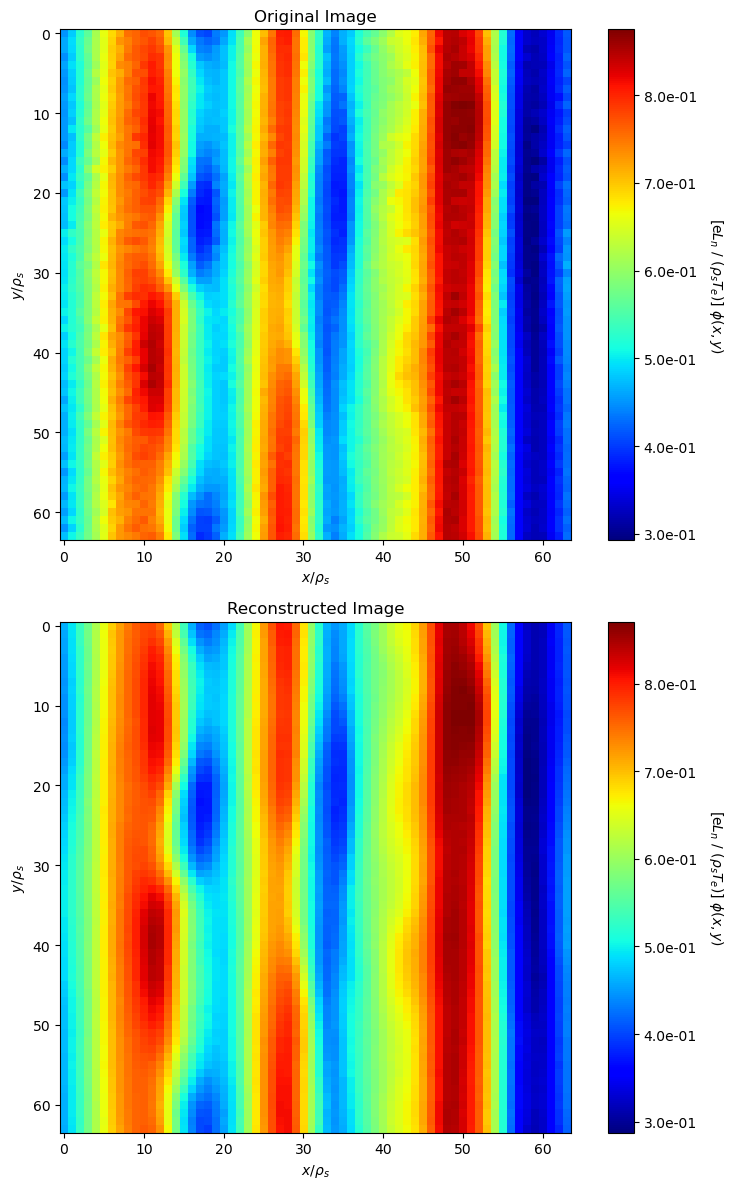

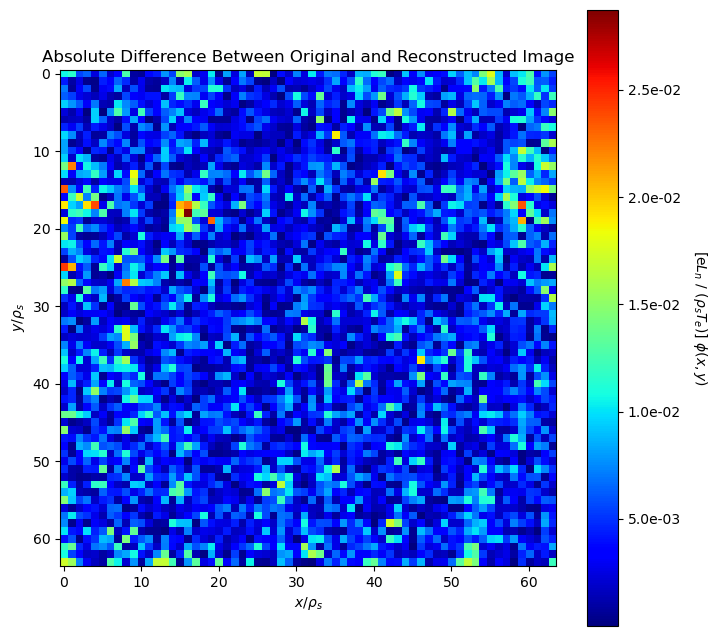

In [41]:
it = 31

FLAG_TEST = True

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Get a batch of test data
    test_batch = next(iter(phi_train_loader))
    recon_batch, mu, logvar, z = model(test_batch)
    
    # Select the it-th image from the batch for display
    original_image = test_batch[it].squeeze().numpy()
    reconstructed_image = recon_batch[it].squeeze().numpy()

    # Create a single figure with two vertically-stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

    # Display the original image in the first subplot
    cax1 = ax1.imshow(original_image, cmap='jet', interpolation='nearest')
    cbar1 = fig.colorbar(cax1, ax=ax1, format='%.1e')
    cbar1.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
    ax1.set_title('Original Image')
    ax1.set_xlabel(r'$x / \rho_s$')
    ax1.set_ylabel(r'$y / \rho_s$')

    # Display the reconstructed image in the second subplot
    cax2 = ax2.imshow(reconstructed_image, cmap='jet', interpolation='nearest')
    cbar2 = fig.colorbar(cax2, ax=ax2, format='%.1e')
    cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
    ax2.set_title('Reconstructed Image')
    ax2.set_xlabel(r'$x / \rho_s$')
    ax2.set_ylabel(r'$y / \rho_s$')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.savefig(f'CVAE Training/CVAE_2/Reconstruction_train_{it}.png')
    plt.show()
    
if FLAG_TEST:
    original_image = test_batch[it].squeeze().numpy()
    reconstructed_image = recon_batch[it].squeeze().numpy()
    
    # calculate difference
    diff = np.abs(original_image - reconstructed_image)
    
    # plot difference
    plt.figure(figsize=(8, 8))
    
    plt.imshow(diff, cmap='jet', interpolation='nearest')
    cbar = plt.colorbar(format='%.1e')
    cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
    plt.title('Absolute Difference Between Original and Reconstructed Image')
    plt.xlabel(r'$x / \rho_s$')
    plt.ylabel(r'$y / \rho_s$')
    plt.savefig(f'CVAE Training/CVAE_2/Difference_train_{it}.png')
    plt.show()

### Save Model (Optional)

In [ ]:
# save model
#torch.save(model.state_dict(), 'CVAE_model.pth')

## DNN Model

For the DNN Model our testing and training datasets are the latent-space representations $\mathrm{z}$ of the testing and training images, respectively. We train the model to predict the next latent-space representation $\mathrm{z_{i+1}}$ given the previous one $\mathrm{z_{i}}$.

Our datasets will then have shape $[n_{trainbatch} \times batchsize, 64]$ and $[n_{testbatch} \times batchsize, 64]$

Retrieve the data as model outputs

In [ ]:
# for each batch in the training and test set, get the latent space representation and tehen append these to a tensor of dimension (batch_size * batch_dim, latent_dim)

# get length of training and test set
train_len = len(phi_train_loader.dataset)
test_len = len(phi_test_loader.dataset)

# initialize empty tensors to store z-vectors
z_train_data = torch.empty(train_len, latent_dim)
z_test_data = torch.empty(test_len, latent_dim)

# get z-vectors for training and test set
model.eval()
with torch.no_grad():
    for i, batch in enumerate(phi_train_loader):
        _, _, _, z = model(batch)
        z_train_data[i*batch_size_cvae:(i+1)*batch_size_cvae, :] = z
        
    for i, batch in enumerate(phi_test_loader):
        _, _, _, z = model(batch)
        z_test_data[i*batch_size_cvae:(i+1)*batch_size_cvae, :] = z
        
# print shapes of data
print(z_train_data.shape)
print(z_test_data.shape)


torch.Size([512, 128])
torch.Size([32, 128])


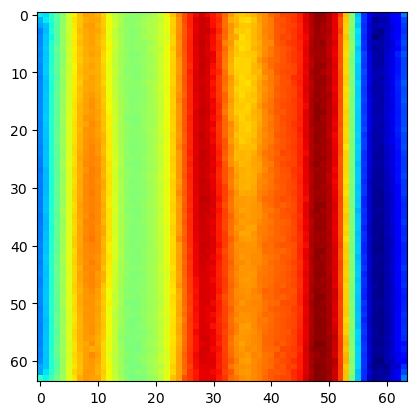

In [ ]:
# test that decoder works
reconstructed = model.decoder(z_train_data[42].unsqueeze(0))

plt.figure()
plt.imshow(reconstructed.squeeze().detach().numpy(), cmap='jet')

### Define Dataset and create DataLoader

In [ ]:
# define class for dataset
class ZDataset(Dataset):
    def __init__(self, z_data):
        self.data = z_data

    def __len__(self):
        return (self.data.shape[0] - 1) # the sataset consists of samples and targets, but there are only n-1 targets

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.data[idx + 1]
        return sample, target
    
# train data loader
z_train = ZDataset(z_train_data)
z_train_loader = DataLoader(z_train, batch_size=batch_size_dnn, shuffle=True)

# test data loader
z_test = ZDataset(z_test_data)
z_test_loader = DataLoader(z_test, batch_size=batch_size_dnn, shuffle=True)

# test data loader
print("Train Data Loader")
for sample, target in z_train_loader:
    print(sample.shape, target.shape)
    
print("Test Data Loader")
for sample, target in z_test_loader:
    print(sample.shape, target.shape)
    

Train Data Loader
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([31, 128]) torch.Size([31, 128])
Test Data Loader
torch.Size([31, 128]) torch.Size([31, 128])


### Define DNN Model

In [ ]:
# DNN Model
class DNN(nn.Module):
    def __init__(self, latent_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
# test DNN
dnn = DNN(latent_dim)
output = dnn(z_train_data[0].unsqueeze(0))

print(output.size())

torch.Size([1, 128])


Define Loss Function

In [ ]:
# define loss function for DNN
def loss_function_dnn(output, z):
    return F.mse_loss(output, z, reduction='sum')

Initialize Model and Optimizer

In [ ]:
dnnmodel = DNN(latent_dim)
optimizer = optim.Adam(dnnmodel.parameters(), lr=lr_dnn)

### Train Model

In [ ]:
# create loss list to visualize loss
loss_list = []

# Training loop
for epoch in range(num_epochs_dnn):
    dnnmodel.train()
    train_loss = 0
    for i, batch in enumerate(z_train_loader): # get sample and target batches
        sample, target = batch
        optimizer.zero_grad()
        output = dnnmodel(sample)
        loss = loss_function_dnn(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(z_train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs_dnn}, Loss: {avg_loss:.4f}")
    loss_list.append(avg_loss)

# plot loss
plt.figure()
plt.plot(loss_list, color = "m")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DNN Loss')
plt.grid()
plt.show()

Epoch 1/10000, Loss: 261.0718
Epoch 2/10000, Loss: 228.5198
Epoch 3/10000, Loss: 225.6863
Epoch 4/10000, Loss: 223.8307
Epoch 5/10000, Loss: 221.7994
Epoch 6/10000, Loss: 218.7030
Epoch 7/10000, Loss: 212.0779
Epoch 8/10000, Loss: 195.4980
Epoch 9/10000, Loss: 177.1450
Epoch 10/10000, Loss: 162.9041
Epoch 11/10000, Loss: 148.3537
Epoch 12/10000, Loss: 136.1737
Epoch 13/10000, Loss: 129.2945
Epoch 14/10000, Loss: 124.8504
Epoch 15/10000, Loss: 119.0576
Epoch 16/10000, Loss: 115.2188
Epoch 17/10000, Loss: 111.1696
Epoch 18/10000, Loss: 108.2434
Epoch 19/10000, Loss: 104.9714
Epoch 20/10000, Loss: 102.8729
Epoch 21/10000, Loss: 101.2701
Epoch 22/10000, Loss: 99.0872
Epoch 23/10000, Loss: 97.2682
Epoch 24/10000, Loss: 95.9968
Epoch 25/10000, Loss: 94.5167
Epoch 26/10000, Loss: 93.2801
Epoch 27/10000, Loss: 92.2799
Epoch 28/10000, Loss: 90.9646
Epoch 29/10000, Loss: 89.9857
Epoch 30/10000, Loss: 89.2947
Epoch 31/10000, Loss: 88.3040
Epoch 32/10000, Loss: 87.2327
Epoch 33/10000, Loss: 86.938

KeyboardInterrupt: 

## GAIT Model

The GAIT Model Combines the CVAE Model and the DNN to create a Generative Artificial Intelligence Turbulence (GAIT) model to serve as a surrogate for generating the next time steps in turbulence simulations.

In [ ]:
# combine the CVAE and DNN models
class GAIT(nn.Module):
    def __init__(self, cvae, dnn):
        super(GAIT, self).__init__()
        self.cvae = cvae
        self.dnn = dnn

    def forward(self, x):
        mu, logvar = self.cvae.encoder(x)
        z = self.cvae.reparameterize(mu, logvar)
        z_pred = self.dnn(z)
        return self.cvae.decoder(z_pred), mu, logvar, z

Test GAIT Model

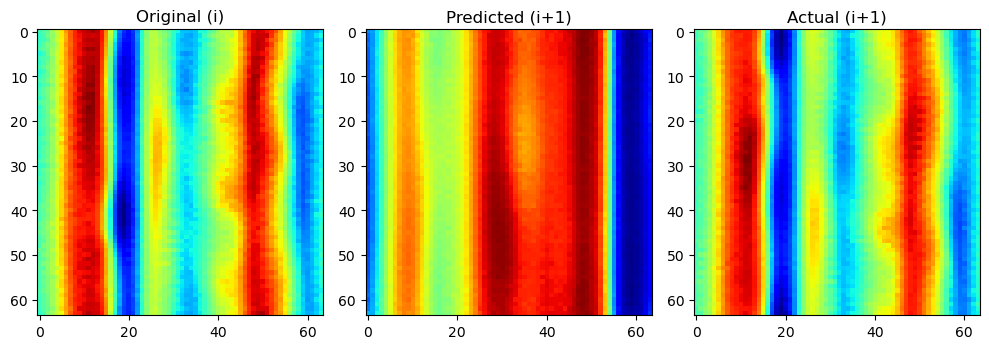

In [ ]:
# test GAIT
gait = GAIT(model, dnnmodel)

# make prediction
it = 20
gait.eval()
with torch.no_grad():
    pred, mu, logvar, z = gait(first_batch)

    # compare original and predicted on same subplot
    fig, ax = plt.subplots(1, 3)
    # set size to 10x5
    fig.set_size_inches(10, 5)
    ax[0].imshow(first_batch[it].squeeze(), cmap='jet')
    ax[0].set_title('Original (i)')
    ax[1].imshow(pred[it].squeeze().detach().numpy(), cmap='jet')
    ax[1].set_title('Predicted (i+1)')
    ax[2].imshow(first_batch[it+1].squeeze(), cmap='jet')
    ax[2].set_title('Actual (i+1)')	
    # set tight layout
    plt.tight_layout()
    plt.show()


